## Tarea 2 Ciencia de Redes. Red de metro Berlin

### Llamado de librerias

In [2]:
import statistics
import cdlib
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.generators.random_graphs import erdos_renyi_graph
import numpy as np
import pandas as pd
from cdlib import algorithms
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
import collections
import pickle
import community as community_louvain
import matplotlib.cm as cm

#### Llamada a las tablas de datos .csv con separador de ";". hdata_subway = Berlin datos del subterraneo

In [3]:
hdata_subway = pd.read_csv(r"C:\Users\civan\Jupyter\Ciencia de redes\Tarea 02\berlin\network_subway.csv", sep=";")
print(hdata_subway.columns.tolist())
print(hdata_subway.shape[0])
hdata_subway

['from_stop_I', 'to_stop_I', 'd', 'duration_avg', 'n_vehicles', 'route_I_counts']
366


,from_stop_I,to_stop_I,d,duration_avg,n_vehicles,route_I_counts
0,2562,2563,1074,120.000000,215,966:215
1,2562,2453,1626,120.000000,216,966:216
2,2563,2609,1328,120.000000,215,966:215
3,2563,2562,1074,120.000000,216,966:216
4,1544,1545,648,60.000000,229,969:229
...,...,...,...,...,...,...
361,1892,1954,545,120.000000,243,963:243
362,1892,1891,632,67.654321,243,963:243
363,426,441,641,120.000000,137,963:137
364,2045,2029,761,120.000000,218,966:218


#### Llamada a las tablas de datos .csv con separador de ";". hdata_node = Berlin datos de los nodos

In [4]:
hdata_node = pd.read_csv(r"C:\Users\civan\Jupyter\Ciencia de redes\Tarea 02\berlin\network_nodes.csv", sep=";")
print(hdata_node.columns.tolist())
print(hdata_node.shape[0])
hdata_node

['stop_I', 'lat', 'lon', 'name']
4601


,stop_I,lat,lon,name
0,105,52.528.318,1.332.026,Wiebestr./Huttenstr.
1,106,52.527.903,13.323.637,Reuchlinstr.
2,107,52.529.103,13.315.981,Neues Ufer
3,108,52.525.756,1.330.984,Ilsenburger Str.
4,109,52.525.797,13.314.261,Goslarer Platz
...,...,...,...,...
4596,10938,52.769.962,13.454.593,"Stolzenhagen, Stolzenfels"
4597,10939,52.611.806,13.594.948,"Blumberg (BAR), Gutshof"
4598,10940,5.260.693,1.360.193,"Blumberg (BAR), Liebigstr."
4599,10946,52.734.171,13.666.572,"Danewitz, Kirche"


De la lista de nodos se se busca cuantos  valores unicos

In [5]:
print(hdata_node.groupby("name").name.nunique())

name
Aalemannufer           1
Abgeordnetenhaus       1
Abtstr.                1
Achardstr.             1
Adalbertstr.           1
                      ..
Zühlslake              1
Züricher Str.          1
Öschelbronner Weg      1
Ützdorf, Dorf          1
Ützdorf, Tierzucht     1
Name: name, Length: 4571, dtype: int64


#### Se crean dos columnas con los nombres de las estaciones dados los codigos que aparecen en las primeras dos columnas de la tabla de hdata_subway

In [6]:
sub_stations = hdata_subway.copy()
sub_stations = sub_stations.merge(hdata_node[["stop_I","name"]], left_on='from_stop_I', right_on='stop_I')
sub_stations = sub_stations.rename(columns={'name': 'from_name'})
sub_stations = sub_stations.merge(hdata_node[["stop_I","name"]], left_on='to_stop_I', right_on='stop_I')
sub_stations = sub_stations.rename(columns={'name': 'to_name'})
sub_stations = sub_stations.drop({'stop_I_x','stop_I_y'}, axis = 1) 
sub_stations

,from_stop_I,to_stop_I,d,duration_avg,n_vehicles,route_I_counts,from_name,to_name
0,2562,2563,1074,120.0,215,966:215,U Biesdorf-Süd,U Elsterwerdaer Platz
1,2609,2563,1328,120.0,216,966:216,S+U Wuhletal,U Elsterwerdaer Platz
2,2562,2453,1626,120.0,216,966:216,U Biesdorf-Süd,U Tierpark
3,2468,2453,1211,120.0,215,966:215,U Friedrichsfelde,U Tierpark
4,2563,2609,1328,120.0,215,966:215,U Elsterwerdaer Platz,S+U Wuhletal
...,...,...,...,...,...,...,...,...
361,2030,2031,772,120.0,217,966:217,U Frankfurter Tor,U Samariterstr.
362,2029,2045,761,60.0,217,966:217,U Strausberger Platz,U Weberwiese
363,2030,2045,741,60.0,218,966:218,U Frankfurter Tor,U Weberwiese
364,2031,2030,772,60.0,218,966:218,U Samariterstr.,U Frankfurter Tor


### Generación del grafo

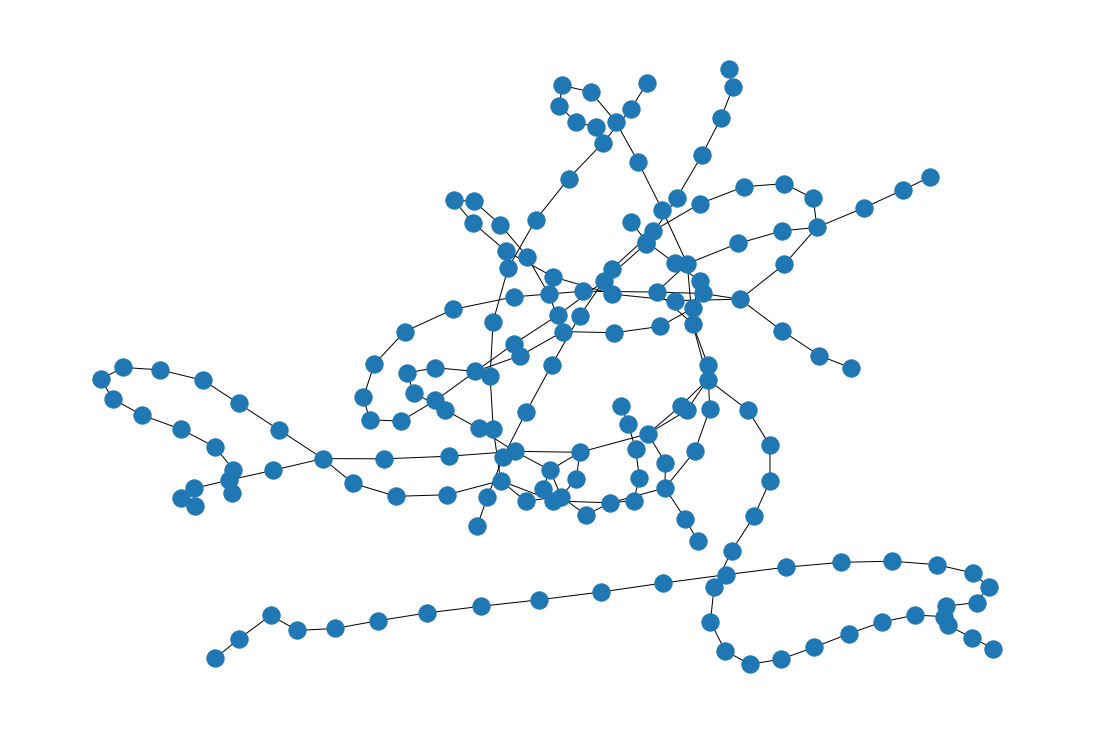

In [7]:
GS = nx.Graph() #Agregamos todos las estaciones como nodos
stations = np.append(sub_stations["from_name"].to_numpy(),sub_stations["to_name"].to_numpy()) 

stations = np.unique(stations) #Obtenemos valores unicos

nodes = set(stations)
GS.add_nodes_from(nodes) #Agrega cada estacion como un nodo

for index, row in sub_stations.iterrows(): #Agrego los enlaces
    GS.add_edge(row['from_name'], row['to_name'])
    
plt.figure(figsize=(15,10))
pos = nx.spring_layout(GS)

nx.draw(GS,pos,with_labels=False) #nx.draw(G,pos,with_labels=True)

In [8]:
print(GS.number_of_edges())
print(GS.number_of_nodes())
print(nx.number_connected_components(GS))
largest_cc = max(nx.connected_components(GS), key=len)
Short_cc = min(nx.connected_components(GS), key=len)
print(len(Short_cc))
print(len(largest_cc))

183
175
3
3
152


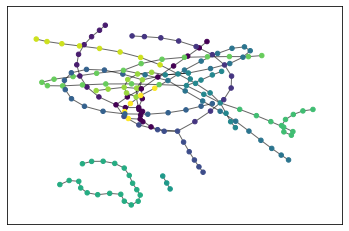

In [23]:
partition = community_louvain.best_partition(GS) #Primer computo de la primera partición

partition = community_louvain.best_partition(GS) # Calcula la mejor partición

pos = nx.spring_layout(GS) # dibuja el grapho
cmap = cm.get_cmap('viridis', max(partition.values()) + 1) # color de los nodos dada la particion
nx.draw_networkx_nodes(GS, pos, partition.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(GS, pos, alpha=0.6)
plt.show()

In [10]:
print("Centralidad Intermedia")
b = nx.betweenness_centrality(GS)
b

Centralidad Intermedia


{'U Uhlandstr.  ': 0.0,
 'U Augsburger Str.  ': 0.01035590104754944,
 'U Blissestr.  ': 0.06415963501871415,
 'U Schloßstr.  ': 0.009966115208291807,
 'U Breitenbachplatz  ': 0.05780346820809248,
 'U Friedrich-Wilhelm-Platz  ': 0.02949970101654375,
 'U Haselhorst  ': 0.02949970101654375,
 'U Kaiserdamm  ': 0.02949970101654375,
 'U Vinetastr.  ': 0.009966115208291807,
 'U Alt-Tegel  ': 0.0,
 'U Klosterstr.  ': 0.06697229419972095,
 'U Gneisenaustr.  ': 0.11288286492591854,
 'S+U Berlin Hauptbahnhof': 0.0,
 'U Neue Grottkauer Str.  ': 0.003986446083316723,
 'S+U Potsdamer Platz (Bln) [U2]': 0.11919473789117001,
 'S+U Wedding  ': 0.05419351981042236,
 'U Holzhauser Str.  ': 0.019799348880473057,
 'S+U Hermannstr.  ': 0.0,
 'U Spichernstr.  ': 0.06729674661705759,
 'S+U Neukölln   [U7]': 0.0849113015746462,
 'U Moritzplatz  ': 0.06537328638185724,
 'U Mehringdamm  ': 0.1862002524749186,
 'U Möckernbrücke  ': 0.24976856465794087,
 'U Görlitzer Bahnhof  ': 0.019799348880473057,
 'U Mohrenstr

In [11]:
print("Centralidad de Grados")
d = nx.degree_centrality(GS)
(d)

Centralidad de Grados


{'U Uhlandstr.  ': 0.005747126436781609,
 'U Augsburger Str.  ': 0.011494252873563218,
 'U Blissestr.  ': 0.011494252873563218,
 'U Schloßstr.  ': 0.011494252873563218,
 'U Breitenbachplatz  ': 0.011494252873563218,
 'U Friedrich-Wilhelm-Platz  ': 0.011494252873563218,
 'U Haselhorst  ': 0.011494252873563218,
 'U Kaiserdamm  ': 0.011494252873563218,
 'U Vinetastr.  ': 0.011494252873563218,
 'U Alt-Tegel  ': 0.005747126436781609,
 'U Klosterstr.  ': 0.011494252873563218,
 'U Gneisenaustr.  ': 0.011494252873563218,
 'S+U Berlin Hauptbahnhof': 0.005747126436781609,
 'U Neue Grottkauer Str.  ': 0.011494252873563218,
 'S+U Potsdamer Platz (Bln) [U2]': 0.011494252873563218,
 'S+U Wedding  ': 0.011494252873563218,
 'U Holzhauser Str.  ': 0.011494252873563218,
 'S+U Hermannstr.  ': 0.005747126436781609,
 'U Spichernstr.  ': 0.022988505747126436,
 'S+U Neukölln   [U7]': 0.011494252873563218,
 'U Moritzplatz  ': 0.011494252873563218,
 'U Mehringdamm  ': 0.022988505747126436,
 'U Möckernbrücke  '

In [12]:
print("Centralidad Cercana")
c = nx.closeness_centrality(GS)
c

Centralidad Cercana


{'U Uhlandstr.  ': 0.08609739151449243,
 'U Augsburger Str.  ': 0.09176486686628674,
 'U Blissestr.  ': 0.08325300500956638,
 'U Schloßstr.  ': 0.06333505552685233,
 'U Breitenbachplatz  ': 0.0657502407852772,
 'U Friedrich-Wilhelm-Platz  ': 0.07382548162538449,
 'U Haselhorst  ': 0.04599516668482186,
 'U Kaiserdamm  ': 0.06857154886711536,
 'U Vinetastr.  ': 0.04058229479252322,
 'U Alt-Tegel  ': 0.04299220140585875,
 'U Klosterstr.  ': 0.05526791644245359,
 'U Gneisenaustr.  ': 0.08609739151449243,
 'S+U Berlin Hauptbahnhof': 0.007662835249042145,
 'U Neue Grottkauer Str.  ': 0.015959328028293546,
 'S+U Potsdamer Platz (Bln) [U2]': 0.08267522390224445,
 'S+U Wedding  ': 0.07160668299729916,
 'U Holzhauser Str.  ': 0.04765099268547544,
 'S+U Hermannstr.  ': 0.061899022146933144,
 'U Spichernstr.  ': 0.08938624139499146,
 'S+U Neukölln   [U7]': 0.0635192583058931,
 'U Moritzplatz  ': 0.0797081690298403,
 'U Mehringdamm  ': 0.09306834508881923,
 'U Möckernbrücke  ': 0.09670865674173984,

In [13]:
centrality = nx.eigenvector_centrality(GS,max_iter=200)
sorted((v, f"{c:0.2f}") for v, c in centrality.items())
centrality

{'U Uhlandstr.  ': 0.1299047989801687,
 'U Augsburger Str.  ': 0.23375796887793138,
 'U Blissestr.  ': 0.06669475037826043,
 'U Schloßstr.  ': 0.0023207283867193447,
 'U Breitenbachplatz  ': 0.004499228518046566,
 'U Friedrich-Wilhelm-Platz  ': 0.01670564412158013,
 'U Haselhorst  ': 4.675223706417771e-06,
 'U Kaiserdamm  ': 0.004365247296125831,
 'U Vinetastr.  ': 2.0024075417979201e-07,
 'U Alt-Tegel  ': 1.9974818846000397e-07,
 'U Klosterstr.  ': 7.172271250615801e-05,
 'U Gneisenaustr.  ': 0.052025204595921505,
 'S+U Berlin Hauptbahnhof': 7.843908218893821e-38,
 'U Neue Grottkauer Str.  ': 5.614010726056954e-23,
 'S+U Potsdamer Platz (Bln) [U2]': 0.025182381646219942,
 'S+U Wedding  ': 0.0005950050996963364,
 'U Holzhauser Str.  ': 1.6377489526043929e-06,
 'S+U Hermannstr.  ': 0.0007753480192554088,
 'U Spichernstr.  ': 0.292585356260245,
 'S+U Neukölln   [U7]': 0.0009031068257545065,
 'U Moritzplatz  ': 0.011705520269406291,
 'U Mehringdamm  ': 0.13502706379580054,
 'U Möckernbrüc

In [14]:
sorted(nx.closeness_centrality(GS).items(), key=lambda x: x[1], reverse=True)

[('U Nollendorfplatz  ', 0.09980215528184118),
 ('U Wittenbergplatz  ', 0.0991227154955049),
 ('U Kurfürstenstr.  ', 0.09860062444323361),
 ('U Bülowstr.  ', 0.09860062444323361),
 ('U Gleisdreieck  ', 0.09786424935403844),
 ('S+U Zoologischer Garten Bhf  ', 0.09779121633213243),
 ('U Möckernbrücke  ', 0.09670865674173984),
 ('U Kurfürstendamm  ', 0.09551037163633926),
 ('U Hallesches Tor  ', 0.09427354667989746),
 ('U Mehringdamm  ', 0.09306834508881923),
 ('U Viktoria-Luise-Platz  ', 0.09280469538601804),
 ('U Hansaplatz  ', 0.09208730139498064),
 ('U Augsburger Str.  ', 0.09176486686628674),
 ('U Ernst-Reuter-Platz  ', 0.09055993772291462),
 ('S+U Yorckstr.  ', 0.09031028937633181),
 ('U Bayerischer Platz  ', 0.08993838701788433),
 ('U Mendelssohn-Bartholdy-Park  ', 0.08969214913419403),
 ('U Spichernstr.  ', 0.08938624139499146),
 ('U Prinzenstr.  ', 0.08914301352724999),
 ('U Kochstr./Checkpoint Charlie  ', 0.08836158454825183),
 ('U Eisenacher Str.  ', 0.08818319642332266),
 ('U 

In [15]:
sorted(nx.eigenvector_centrality(GS,max_iter=200).items(), key=lambda x: x[1], reverse=True)

[('U Wittenbergplatz  ', 0.4163770250940453),
 ('U Kurfürstendamm  ', 0.39398778491348374),
 ('S+U Zoologischer Garten Bhf  ', 0.35605566752691375),
 ('U Spichernstr.  ', 0.292585356260245),
 ('U Nollendorfplatz  ', 0.27902054967788453),
 ('U Augsburger Str.  ', 0.23375796887793138),
 ('U Gleisdreieck  ', 0.17766490301176832),
 ('U Möckernbrücke  ', 0.17074018559003484),
 ('U Kurfürstenstr.  ', 0.15058417047102238),
 ('U Bülowstr.  ', 0.15058417047102238),
 ('U Hallesches Tor  ', 0.13585534534005353),
 ('U Ernst-Reuter-Platz  ', 0.1354762451240876),
 ('U Güntzelstr.  ', 0.13535530896291662),
 ('U Mehringdamm  ', 0.13502706379580054),
 ('U Hansaplatz  ', 0.1340374647146139),
 ('U Uhlandstr.  ', 0.1299047989801687),
 ('U Viktoria-Luise-Platz  ', 0.12867661344236767),
 ('U Hohenzollernplatz  ', 0.12428036213025265),
 ('U Berliner Str.  ', 0.11793321570820346),
 ('U Bayerischer Platz  ', 0.1112343389295268),
 ('U Fehrbelliner Platz  ', 0.08434496517903087),
 ('S+U Yorckstr.  ', 0.069223456

In [16]:
sorted(nx.degree_centrality(GS).items(), key=lambda x: x[1], reverse=True)

[('U Spichernstr.  ', 0.022988505747126436),
 ('U Mehringdamm  ', 0.022988505747126436),
 ('U Möckernbrücke  ', 0.022988505747126436),
 ('U Wittenbergplatz  ', 0.022988505747126436),
 ('U Leopoldplatz  ', 0.022988505747126436),
 ('U Hermannplatz  ', 0.022988505747126436),
 ('U Bayerischer Platz  ', 0.022988505747126436),
 ('U Kottbusser Tor  ', 0.022988505747126436),
 ('U Fehrbelliner Platz  ', 0.022988505747126436),
 ('U Nollendorfplatz  ', 0.022988505747126436),
 ('U Hallesches Tor  ', 0.022988505747126436),
 ('S+U Zoologischer Garten Bhf  ', 0.022988505747126436),
 ('U Kurfürstendamm  ', 0.022988505747126436),
 ('U Bismarckstr.  ', 0.022988505747126436),
 ('U Gleisdreieck  ', 0.022988505747126436),
 ('U Berliner Str.  ', 0.022988505747126436),
 ('U Osloer Str.  ', 0.017241379310344827),
 ('U Augsburger Str.  ', 0.011494252873563218),
 ('U Blissestr.  ', 0.011494252873563218),
 ('U Schloßstr.  ', 0.011494252873563218),
 ('U Breitenbachplatz  ', 0.011494252873563218),
 ('U Friedrich-W

In [17]:
sorted(nx.betweenness_centrality(GS).items(), key=lambda x: x[1], reverse=True)

[('S+U Zoologischer Garten Bhf  ', 0.26426704759373687),
 ('U Möckernbrücke  ', 0.24976856465794087),
 ('U Gleisdreieck  ', 0.24911523043873066),
 ('U Nollendorfplatz  ', 0.2143135561313756),
 ('U Wittenbergplatz  ', 0.19566916926893013),
 ('U Mehringdamm  ', 0.1862002524749186),
 ('U Leopoldplatz  ', 0.18302659845414476),
 ('U Bismarckstr.  ', 0.1658084734126193),
 ('U Hallesches Tor  ', 0.15927623856665113),
 ('U Hansaplatz  ', 0.15334972205612032),
 ('U Turmstr.  ', 0.14794587292095768),
 ('U Ernst-Reuter-Platz  ', 0.14693929528492014),
 ('U Birkenstr.  ', 0.14267490532190558),
 ('U Deutsche Oper  ', 0.14049454078355814),
 ('U Hermannplatz  ', 0.14032290213274864),
 ('S+U Westhafen  ', 0.13753681925896405),
 ('U Amrumer Str.  ', 0.1326644962682436),
 ('U Mendelssohn-Bartholdy-Park  ', 0.12743339313002458),
 ('S+U Potsdamer Platz (Bln) [U2]', 0.11919473789117001),
 ('U Kottbusser Tor  ', 0.1166655593205324),
 ('U Fehrbelliner Platz  ', 0.11360706929772106),
 ('U Gneisenaustr.  ', 0.1

In [20]:
print(nx.degree_pearson_correlation_coefficient(GS))

0.1683708248125425
